In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR10
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# Sample the first 1000 examples from each class
class_indices = {i: np.where(np.array(trainset_full.targets) == i)[0][:1000] for i in range(10)}
sampled_indices = np.hstack(list(class_indices.values()))

# shuffle
np.random.shuffle(sampled_indices)
trainset = Subset(trainset_full, sampled_indices)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 56246330.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# ResNet18 model
net = resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)  # Adjusting the last layer for 10 classes
net = net.to(device)

# loss
criterion = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [6]:
# cross entropy loss
def cross_entropy(pred, soft_targets):
    if not isinstance(soft_targets, torch.Tensor):
        soft_targets = torch.tensor(soft_targets).to(pred.device)
    log_softmax = torch.log_softmax(pred, dim=1)
    return torch.mean(torch.sum(-soft_targets * log_softmax, dim=1))

# one hot encoding
def one_hot(labels, num_classes):
    if labels.ndim == 1:
        y_one_hot = np.zeros((labels.shape[0], num_classes), dtype=np.float32)
        y_one_hot[np.arange(labels.shape[0]), labels.astype(int)] = 1
    elif labels.ndim == 2:
        y_one_hot = labels
    return y_one_hot

# Mixup augmentation
def mixup_data(x, y, alpha=0.4, num_classes=10):
    batch_size = x.shape[0]
    lam = np.random.beta(alpha, alpha, size=batch_size).astype(np.float32)
    indices = np.random.permutation(batch_size)

    mixed_x = lam.reshape(-1, 1, 1, 1) * x + (1 - lam).reshape(-1, 1, 1, 1) * x[indices]

    y_one_hot = one_hot(y, num_classes)
    y_b_one_hot = one_hot(y[indices], num_classes)

    mixed_y = lam.reshape(-1, 1) * y_one_hot + (1 - lam).reshape(-1, 1) * y_b_one_hot
    return mixed_x, mixed_y, lam

In [7]:
# cutout augmentation
def cutout(image, k=16, p=0.5):
    if np.random.rand() > p:
        return image
    else:
        H, W = image.shape[1], image.shape[2]
        padded_image = np.pad(image, ((0, 0), (k//2, k//2), (k//2, k//2)), mode='constant', constant_values=0)
        center_h = np.random.randint(low=k//2, high=H+k//2)
        center_w = np.random.randint(low=k//2, high=W+k//2)

        cutout_image = padded_image.copy()
        cutout_image[:,
                     center_h-k//2:center_h+k//2,
                     center_w-k//2:center_w+k//2] = 0
        # Removing padding
        cutout_image = cutout_image[:, k//2:-k//2, k//2:-k//2]
        return cutout_image

In [ ]:
# standard augmentation
def standard(image, k=4):
    k1, k2 = np.random.randint(-k, k+1, size=2)
    image = np.pad(image, [(0, 0), (k, k), (k, k)], mode='constant')
    shifted_image = image[:, k+k1:image.shape[1]-(k-k1), k+k2:image.shape[2]-(k-k2)]

    if np.random.rand() > 0.5:
        shifted_image = shifted_image[:, :, ::-1]

    return shifted_image

In [8]:
# convert numpy array to tensor
def to_tensor(numpy_array):
    return torch.tensor(numpy_array).float().to(device)

In [9]:
train_ac = []
teat_ac = []
loss_ = []

for epoch in range(100):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        inputs, targets = inputs.numpy(), labels.numpy()

        mixed_inputs, mixed_targets, _ = mixup_data(inputs, targets)
        mixed_inputs = torch.from_numpy(mixed_inputs).float().to(device)
        mixed_targets = torch.from_numpy(mixed_targets).float().to(device)

        optimizer.zero_grad()
        outputs = net(mixed_inputs)
        loss = cross_entropy(outputs, mixed_targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = calculate_accuracy(trainloader, net)
    test_accuracy = calculate_accuracy(testloader, net)
    train_loss = running_loss / len(trainloader)
    train_ac.append(train_accuracy)
    teat_ac.append(test_accuracy)

    if epoch > 10:
        if train_loss > loss_[-1]:
            loss_.append(train_loss)
            print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, '
            f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')
            print('early break')
            break
    loss_.append(train_loss)

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, '
          f'Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')
    print(train_ac)
    print(teat_ac)
    print(loss_)

print('Finished Training')

Epoch 1, Loss: 1.990364268327215, Train Accuracy: 42.61, Test Accuracy: 40.58
[42.61]
[40.58]
[1.990364268327215]
Epoch 2, Loss: 1.7800578729362244, Train Accuracy: 50.47, Test Accuracy: 46.67
[42.61, 50.47]
[40.58, 46.67]
[1.990364268327215, 1.7800578729362244]
Epoch 3, Loss: 1.669692246017942, Train Accuracy: 55.12, Test Accuracy: 49.42
[42.61, 50.47, 55.12]
[40.58, 46.67, 49.42]
[1.990364268327215, 1.7800578729362244, 1.669692246017942]
Epoch 4, Loss: 1.5828225491153207, Train Accuracy: 59.67, Test Accuracy: 53.14
[42.61, 50.47, 55.12, 59.67]
[40.58, 46.67, 49.42, 53.14]
[1.990364268327215, 1.7800578729362244, 1.669692246017942, 1.5828225491153207]
Epoch 5, Loss: 1.500610571758003, Train Accuracy: 60.32, Test Accuracy: 52.41
[42.61, 50.47, 55.12, 59.67, 60.32]
[40.58, 46.67, 49.42, 53.14, 52.41]
[1.990364268327215, 1.7800578729362244, 1.669692246017942, 1.5828225491153207, 1.500610571758003]
Epoch 6, Loss: 1.4285054389078906, Train Accuracy: 66.65, Test Accuracy: 56.6
[42.61, 50.47,

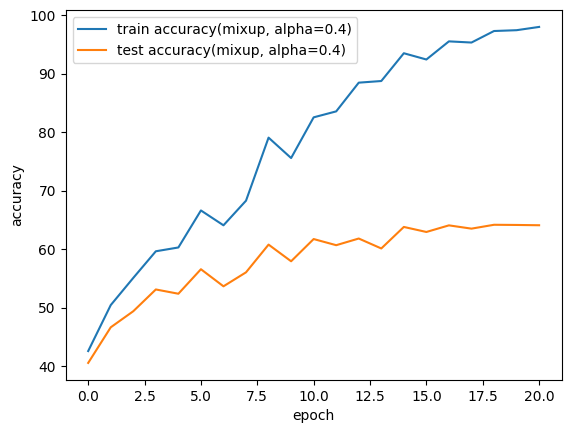

In [13]:
import matplotlib.pyplot as plt

temp = [i for i in range(len(train_ac))]

plt.plot(temp, train_ac, label=f'train accuracy(mixup, alpha=0.4)')
plt.plot(temp, teat_ac, label=f'test accuracy(mixup, alpha=0.4)')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

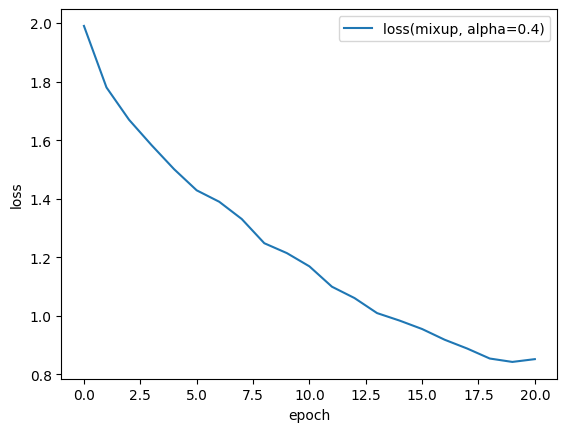

In [14]:
temp = [i for i in range(len(train_ac))]
plt.plot(temp, loss_, label=f'loss(mixup, alpha=0.4)')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()